# Surface Code Encoding

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
import matplotlib.pyplot as plt

## Stabilizer Eigenstates

Following Fowler et. al [1], we see that the two-qubit operators $Z_a Z_b$ commute with $X_a X_b$. The eigenstates of these *stabilizers* are the Bell states (**Table II**):

<p align="center">
<img width="245" alt="stabilizer-eigenstates" src="https://user-images.githubusercontent.com/293681/88832601-0f9a5800-d19f-11ea-88fe-a8191e21a67e.png">
</p>
**** something about ancilla qubit and error measurement as projector ****

[1] Fowler, A. G., Mariantoni, M., Martinis, J. M. & Cleland, A. N. Surface codes: Towards practical large-scale quantum computation. Phys. Rev. A 86, 032324 (2012).


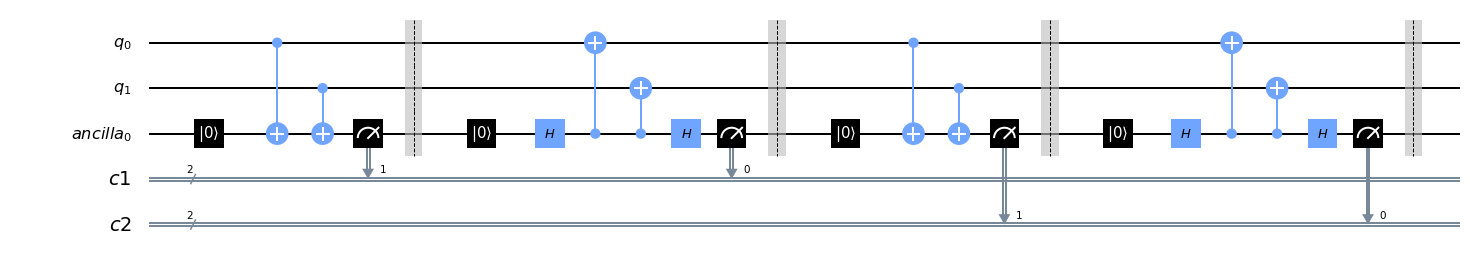

In [3]:
qr = QuantumRegister(2, name='q')
an = QuantumRegister(1, name='ancilla')

rounds = 2
measurements = [ClassicalRegister(2, name="c{}".format(i+1)) for i in range(rounds)]

circ = QuantumCircuit(qr, an, *measurements)

def ZZ_meas(round):
    circ.reset(an)
    circ.cx(0, 2)
    circ.cx(1, 2)
    circ.measure(an, measurements[round][1])
    circ.barrier()

def XX_meas(round):
    circ.reset(an)
    circ.h(an)
    circ.cx(an, 0)
    circ.cx(an, 1)
    circ.h(an)
    circ.measure(an, measurements[round][0])
    circ.barrier()

for i in range(rounds):
    ZZ_meas(i)
    XX_meas(i)

circ.draw(output='mpl', fold=35)

Running this circuit on the four Bell states, and the stabilizer is stable:

Bell state ii: {'00 00': 1}
Bell state ix: {'10 10': 1}
Bell state xi: {'01 01': 1}
Bell state xx: {'11 11': 1}


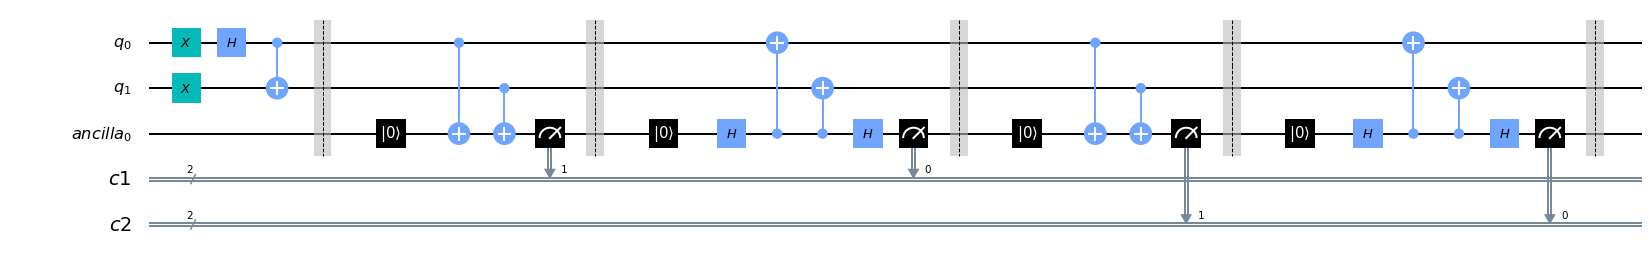

In [4]:
import itertools
for q0_gate, q1_gate in itertools.product(["i", "x"], repeat=2):  
    test_circ = QuantumCircuit(qr, an, *measurements)
    
    # Set up our Bell "generator" states
    getattr(test_circ, q0_gate)(0) #i.e. test_circ.i(0) or test_circ.x(0)
    getattr(test_circ, q1_gate)(1) #i.e. test_circ.i(1) or test_circ.x(1)
    
    # Create Bell state
    test_circ.h(0)
    test_circ.cx(0, 1)
    test_circ.barrier()

    test_circ = test_circ.combine(circ)
    print("Bell state %s%s:" % (q0_gate, q1_gate), execute(test_circ, Aer.get_backend('qasm_simulator'), shots=1).result().get_counts())
# Final Circuit Example
test_circ.draw(output='mpl', fold=35)

Even though our projective measurement is only on the ancilla qubit, all of our qubits are entangled through the stabilizer measurement process. Thus, the ancilla measurement *does* induce back-action on our actual qubit. For example, let's run the circuit on the $|00\rangle$ state, which is **not** a mutual eigenstate of the stabilizers:

In [5]:
execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()

{'01 01': 494, '00 00': 530}

Roughly half of the time we get `00 00`, and the other half `01 01`. If you go through the circuit, it's straightforward to verify that the first $XX$ measurement will project $|00\rangle$ into either the $|00\rangle$ + $|11\rangle$ or $|00\rangle$ - $|11\rangle$ Bell state (and their respective stabilizer eigenvalues).

In the absence of errors, subsequent measurements of the eigenvalue after the first stabilizer measurement will remain the same! This is known as the *quiescent state* of the code, and is an important part of the initialization process for surface codes.

## d=3 Surface Code with 17 Qubits

Following [2], we can generalize this into a d=3 rotated surface code with 9 data qubits and 8 ancillas. Please see the reference for details about how the circuit is constructed, including a subtlety with the direction of stabilzer measurements in each cell.

[2] Tomita, Y. & Svore, K. M. Low-distance surface codes under realistic quantum noise. Phys. Rev. A 90, 062320 (2014).

In [6]:
import sys
sys.path.insert(0, "../")
from surface_code.circuits import SurfaceCodeLogicalQubit

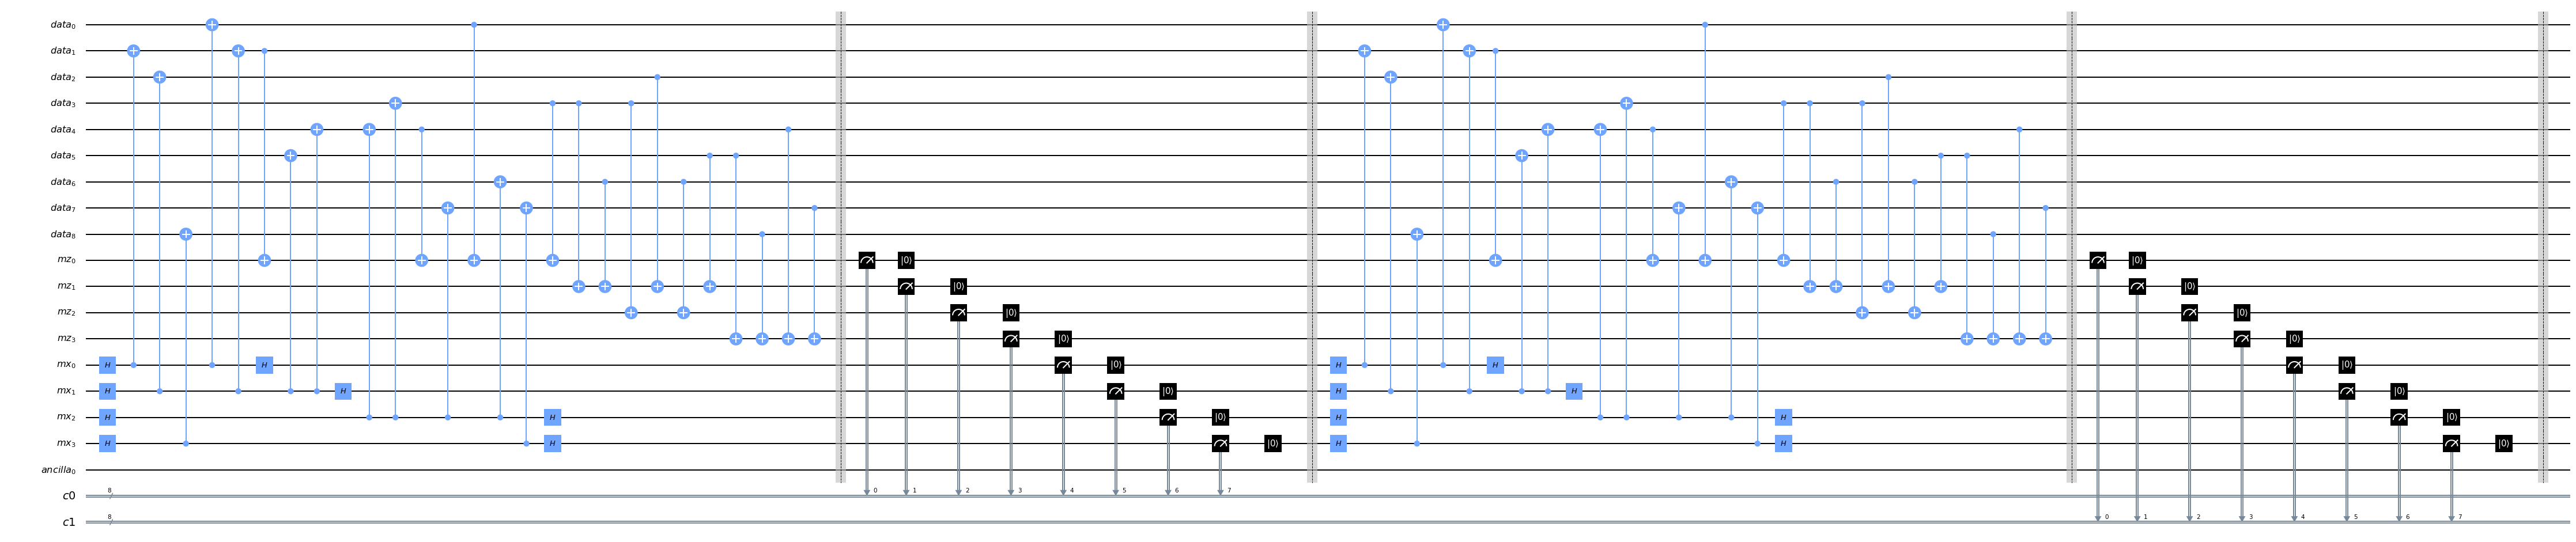

In [7]:
qubit = SurfaceCodeLogicalQubit(3)
qubit.stabilize()
qubit.stabilize()
qubit.draw(output='mpl', fold=100)

Just like before, the $XXXX$ measurements will project our starting state into a quiescent state. Similarly, the $ZZZZ$ measurement doesn't do anything here, since both the starting state and the quiescent states are already Z-eigenstates.

We make four different $XXXX$ measurements, and each has two eigenvalues, so in this case there are $2^4 = 16$ possible combinations of syndrome measurements.

We can run this on the simulator and confirm. We see 3 groups of 8 bits, which are the syndrome measurement rounds. These are stable, and the first 4 bits permute through the 16 possible $XXXX$ syndromes:

In [8]:
execute(qubit, Aer.get_backend('qasm_simulator')).result().get_counts()

{'01000000 01000000': 68,
 '11110000 11110000': 65,
 '01010000 01010000': 76,
 '10100000 10100000': 83,
 '11010000 11010000': 68,
 '10000000 10000000': 51,
 '10010000 10010000': 65,
 '00010000 00010000': 56,
 '01100000 01100000': 54,
 '00100000 00100000': 70,
 '00110000 00110000': 69,
 '10110000 10110000': 62,
 '11000000 11000000': 62,
 '00000000 00000000': 63,
 '01110000 01110000': 63,
 '11100000 11100000': 49}

**TODO: Describe details of logical codespace definition**

From Decodoku posts by James Wooten:

http://decodoku.blogspot.com/2016/03/6-toric-code-part-2.html

<p align="center">
<img width="290" alt="torus" src="https://1.bp.blogspot.com/-Ws0KSLZI57o/Vt_8-w4u15I/AAAAAAAAAJM/KgTj-zACm3M/s1600/torus.png">
<img width="640" alt="logical-qubit" src="https://3.bp.blogspot.com/-W88UDHv8Jyw/VugssfkcRkI/AAAAAAAAAKI/VL1MyGq_WE0MPXAqfCYACeZcoTw304ekg/s640/6.png">
</p>

In our circuit, the Z-operator can be picked as any row of data qubits. We choose the top row:

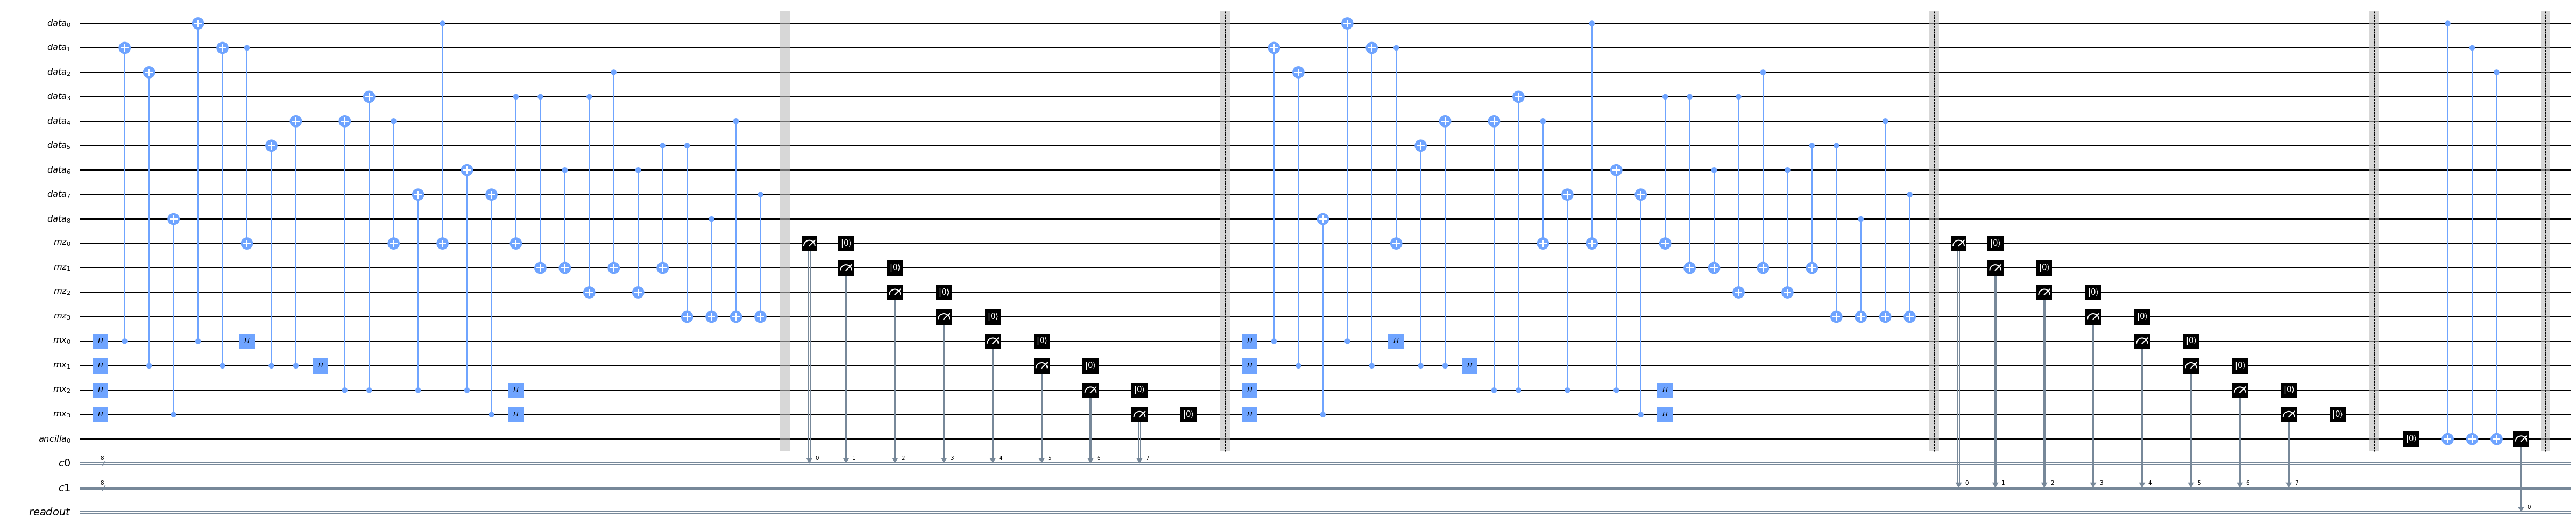

In [9]:
qubit.readout_z()
qubit.draw(output='mpl', fold=150)

In [10]:
execute(qubit, Aer.get_backend('qasm_simulator')).result().get_counts()

{'0 01000000 01000000': 57,
 '0 11110000 11110000': 59,
 '0 01010000 01010000': 58,
 '0 10100000 10100000': 66,
 '0 11010000 11010000': 63,
 '0 10000000 10000000': 72,
 '0 10010000 10010000': 72,
 '0 00010000 00010000': 51,
 '0 01100000 01100000': 52,
 '0 00100000 00100000': 63,
 '0 00110000 00110000': 67,
 '0 10110000 10110000': 63,
 '0 11000000 11000000': 66,
 '0 00000000 00000000': 78,
 '0 01110000 01110000': 69,
 '0 11100000 11100000': 68}

**TODO: Explain X operator?**

Applying the X operator, we can get a $|1_L\rangle$ state:

In [11]:
qubit = SurfaceCodeLogicalQubit(3)
qubit.stabilize()
qubit.stabilize()

qubit.logical_x()
qubit.stabilize()
qubit.readout_z()

execute(qubit, Aer.get_backend('qasm_simulator')).result().get_counts()

{'1 11110000 11110000 11110000': 71,
 '1 01100000 01100000 01100000': 56,
 '1 10000000 10000000 10000000': 74,
 '1 01110000 01110000 01110000': 53,
 '1 01010000 01010000 01010000': 64,
 '1 00100000 00100000 00100000': 68,
 '1 10110000 10110000 10110000': 72,
 '1 00000000 00000000 00000000': 65,
 '1 00110000 00110000 00110000': 60,
 '1 00010000 00010000 00010000': 69,
 '1 11010000 11010000 11010000': 63,
 '1 10100000 10100000 10100000': 66,
 '1 10010000 10010000 10010000': 56,
 '1 01000000 01000000 01000000': 63,
 '1 11000000 11000000 11000000': 54,
 '1 11100000 11100000 11100000': 70}

If we initialize the circuit with $|+\rangle$ data qubits, we get a logical $|+\rangle$ state:

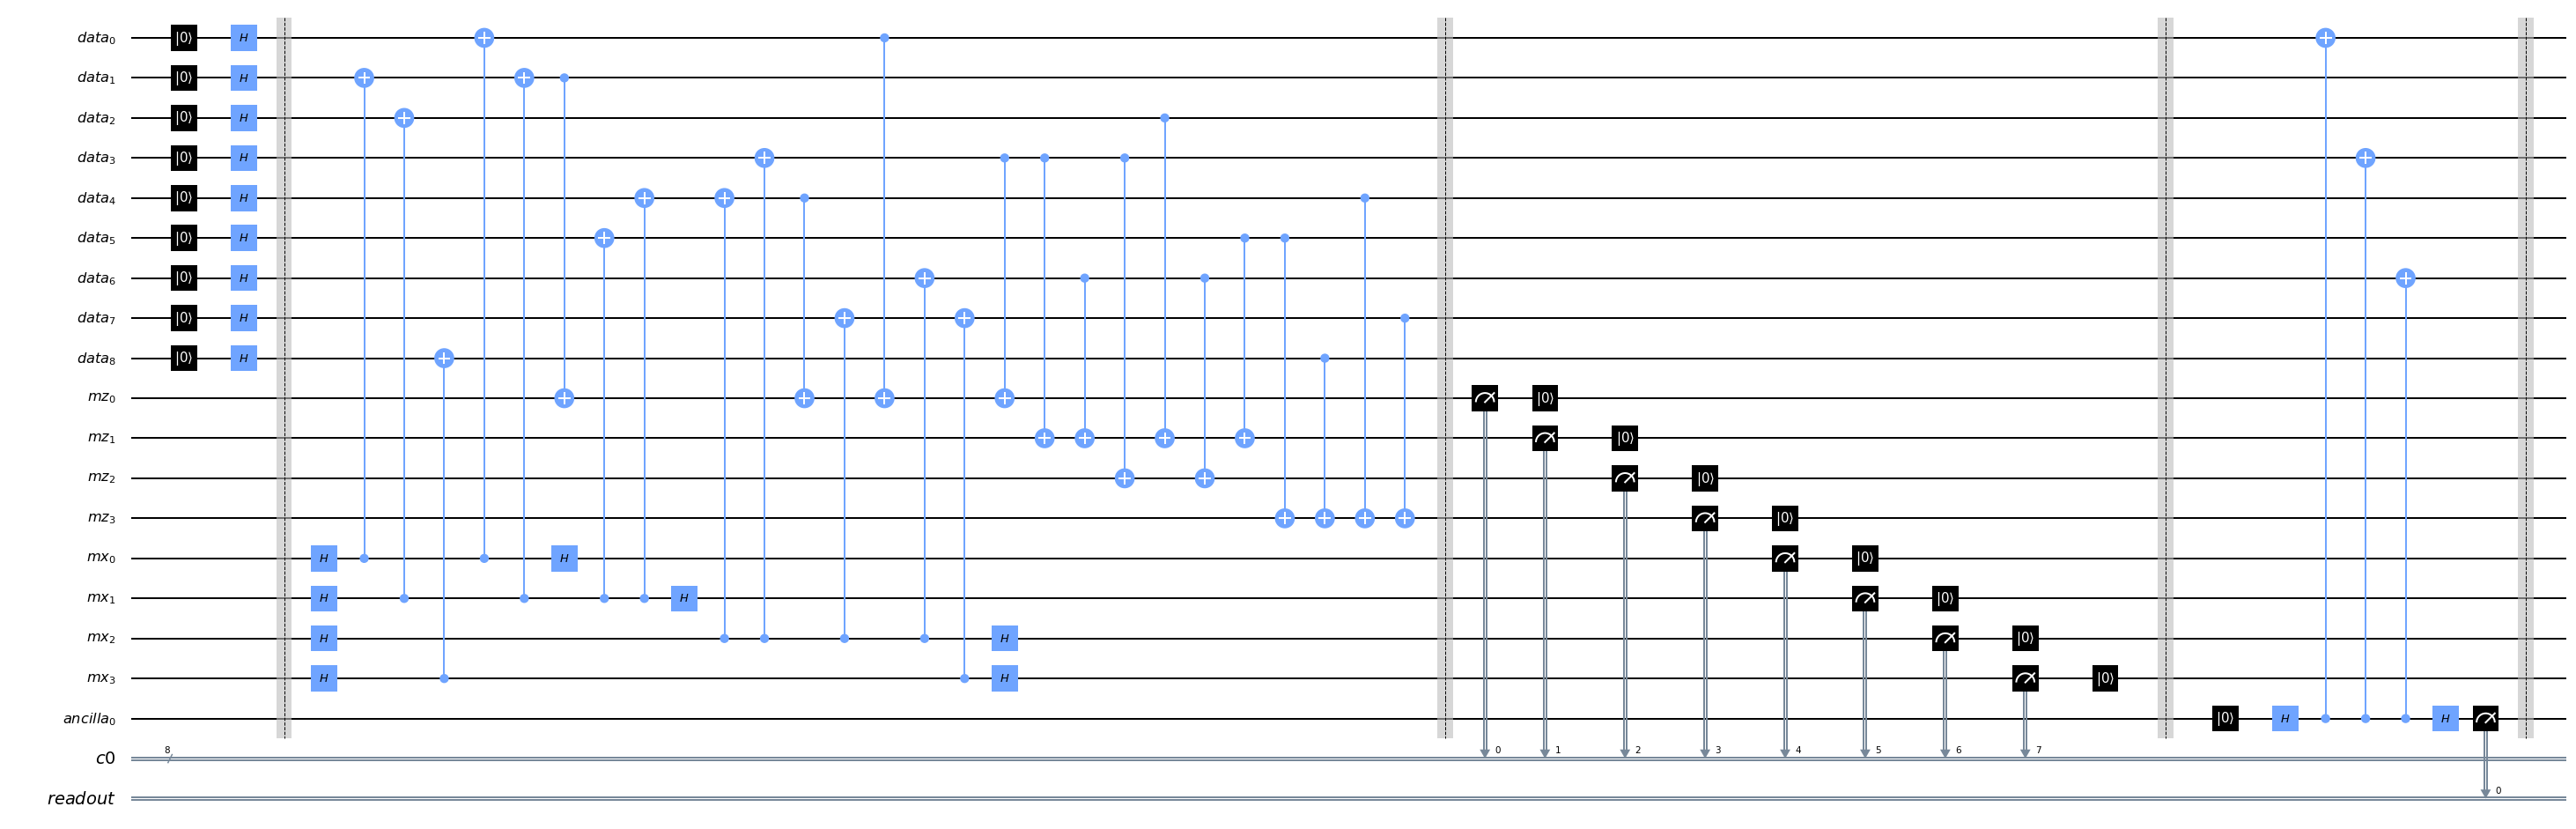

In [12]:
qubit = SurfaceCodeLogicalQubit(3)
qubit.hadamard_reset()
qubit.stabilize()
qubit.stabilize()
qubit.readout_x()  # Note that we need to readout X now instead of Z
qubit.draw(output='mpl', fold=100)

In [13]:
execute(qubit, Aer.get_backend('qasm_simulator')).result().get_counts()

{'0 00000100': 54,
 '0 00001011': 53,
 '0 00001110': 77,
 '0 00001010': 67,
 '0 00000101': 66,
 '0 00000011': 65,
 '0 00000001': 68,
 '0 00001100': 54,
 '0 00000010': 67,
 '0 00000111': 63,
 '0 00001001': 70,
 '0 00001101': 66,
 '0 00000110': 52,
 '0 00001000': 81,
 '0 00000000': 59,
 '0 00001111': 62}

The logical-Z operator will flip this to $|-\rangle$

In [14]:
qubit = SurfaceCodeLogicalQubit(3)
qubit.hadamard_reset()
qubit.stabilize()

qubit.logical_z()

qubit.stabilize()
qubit.readout_x() 

execute(qubit, Aer.get_backend('qasm_simulator')).result().get_counts()

{'1 00001100 00001100': 56,
 '1 00000011 00000011': 63,
 '1 00000101 00000101': 64,
 '1 00001011 00001011': 66,
 '1 00001000 00001000': 62,
 '1 00000100 00000100': 72,
 '1 00000001 00000001': 61,
 '1 00000111 00000111': 73,
 '1 00000110 00000110': 64,
 '1 00000000 00000000': 62,
 '1 00000010 00000010': 68,
 '1 00001001 00001001': 72,
 '1 00001101 00001101': 68,
 '1 00001110 00001110': 57,
 '1 00001010 00001010': 62,
 '1 00001111 00001111': 54}